(aiyagari)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# 艾亚加里模型

```{contents} 目录
:depth: 2
```

除了Anaconda中包含的包之外，本讲座还需要以下库：

In [1]:
!pip install quantecon

## 概述

在本讲座中，我们将描述一类基于Truman Bewley {cite}`Bewley1977`工作的模型结构。

我们首先讨论由Rao Aiyagari {cite}`Aiyagari1994`提出的Bewley模型的一个例子。

该模型具有以下特点：

* 异质性主体
* 单一的借贷工具
* 对个人主体借款额度的限制

艾亚加里模型已被用于研究多个主题，包括：

* 预防性储蓄和流动性约束的影响 {cite}`Aiyagari1994`
* 风险分担和资产定价 {cite}`Heaton1996`
* 财富分布的形状 {cite}`benhabib2015`
* 等等

让我们从导入必要的包开始：

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

plt.rcParams["figure.figsize"] = (11, 5)  #设置默认图形大小
import numpy as np
from quantecon.markov import DiscreteDP
from numba import jit

### 参考文献

本讲座的主要参考文献是 {cite}`Aiyagari1994`。

教科书版本可以在 {cite}`Ljungqvist2012` 的第18章中找到。

SeHyoun Ahn和Benjamin Moll的连续时间版本可以在这里找到：[链接](https://nbviewer.org/github/QuantEcon/QuantEcon.notebooks/blob/master/aiyagari_continuous_time.ipynb)。

## 经济模型

### 家庭

无限期生存的家庭/消费者面临异质性收入冲击。

一个单位区间内的*事前*相同的家庭面临共同的借贷约束。

典型家庭面临的储蓄问题是

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

受约束于

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{且} \quad
a_t \geq -B
$$

其中：

* $c_t$ 是当前消费
* $a_t$ 是资产
* $z_t$ 是劳动收入的随机组成部分，捕捉了失业风险等
* $w$ 是工资率
* $r$ 是净利率
* $B$ 是主体允许借入的最大金额

外生过程 $\{z_t\}$ 遵循一个具有给定转移矩阵 $P$ 的有限状态马尔可夫链。

工资和利率随时间保持不变。

在这个模型的简单版本中，家庭无弹性地供给劳动，因为他们不重视闲暇。

## 企业

企业通过雇佣资本和劳动来生产产出。

企业是竞争性的，面临规模报酬不变。

由于规模报酬不变，企业的数量并不重要。

因此我们可以考虑一个单一的（但仍然是竞争性的）代表性企业。

企业的产出为

$$
Y_t = A K_t^{\alpha} N^{1 - \alpha}
$$

其中：

* $A$ 和 $\alpha$ 是参数，$A > 0$ 且 $\alpha \in (0, 1)$
* $K_t$ 是总资本
* $N$ 是总劳动供给（在这个简单版本的模型中保持不变）

企业的问题是

$$
max_{K, N} \left\{ A K_t^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

参数 $\delta$ 是折旧率。

从关于资本的一阶条件，企业的资本需求反函数为

```{math}
:label: aiy_rgk

r = A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta
```

使用这个表达式和企业关于劳动的一阶条件，我们可以将均衡工资率表示为 $r$ 的函数：

```{math}
:label: aiy_wgr

w(r) = A  (1 - \alpha)  (A \alpha / (r + \delta))^{\alpha / (1 - \alpha)}
```

### 均衡

我们构建一个*平稳理性预期均衡*（SREE）。

在这样的均衡中：

* 价格诱导的行为产生的总量与价格一致
* 总量和价格随时间保持不变

更详细地说，SREE列出了价格、储蓄和生产策略的集合，使得：

* 家庭在给定价格下选择指定的储蓄策略
* 企业在相同价格下最大化利润
* 产生的总量与价格一致；特别是，资本需求等于供给
* 总量（定义为横截面平均值）保持不变

在实践中，一旦参数值设定，我们可以通过以下步骤检查SREE：

1. 选择一个提议的总资本量 $K$
2. 确定相应的价格，其中利率 $r$ 由 {eq}`aiy_rgk` 决定，工资率 $w(r)$ 由 {eq}`aiy_wgr` 给出
3. 确定给定这些价格下家庭的共同最优储蓄策略
4. 计算给定这个储蓄策略下的稳态资本平均值

如果最终数量与 $K$ 一致，那么我们就得到了一个SREE。

## 代码

让我们看看如何在实践中计算这样的均衡。

为了求解家庭的动态规划问题，我们将使用来自 [QuantEcon.py](https://quantecon.org/quantecon-py/) 的 [DiscreteDP](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/markov/ddp.py) 类。

我们的第一个任务是最不令人兴奋的：编写代码，将家庭问题的参数映射到生成 `DiscreteDP` 实例所需的 `R` 和 `Q` 矩阵。

下面是一段样板代码，它完成了这个任务。

在阅读代码时，以下信息会很有帮助：

* `R` 需要是一个矩阵，其中 `R[s, a]` 是在状态 `s` 下采取行动 `a` 的回报。
* `Q` 需要是一个三维数组，其中 `Q[s, a, s']` 是在当前状态为 `s` 且当前行动为 `a` 时转移到状态 `s'` 的概率。

（关于 `DiscreteDP` 的更详细讨论可以在 [Advanced Quantitative Economics with Python](https://python-advanced.quantecon.org) 讲座系列的 [Discrete State Dynamic Programming](https://python-advanced.quantecon.org/discrete_dp.html) 讲座中找到。）

这里我们将状态设为 $s_t := (a_t, z_t)$，其中 $a_t$ 是资产，$z_t$ 是冲击。

行动是选择下一期的资产水平 $a_{t+1}$。

我们使用Numba来加速循环，这样当参数改变时我们可以高效地更新矩阵。

该类还包括一组默认参数，除非另有说明，否则我们将采用这些参数。

In [3]:
class Household:
    """
    这个类接收定义家庭资产积累问题的参数，并计算相应的回报和转移矩阵R
    和Q，这些矩阵是生成DiscreteDP实例所必需的，从而求解最优策略。

    关于索引的说明：我们需要将状态空间S枚举为序列S = {0, ..., n}。
    为此，(a_i, z_i)索引对根据以下规则映射到s_i索引：

        s_i = a_i * z_size + z_i

    要反转这个映射，使用：

        a_i = s_i // z_size  (整数除法)
        z_i = s_i % z_size
    """


    def __init__(self,
                r=0.01,                      # 利率
                w=1.0,                       # 工资
                β=0.96,                      # 贴现因子
                a_min=1e-10,
                Π=[[0.9, 0.1], [0.1, 0.9]],  # 马尔可夫链
                z_vals=[0.1, 1.0],           # 外生状态
                a_max=18,
                a_size=200):

        # 存储值，设置a和z的网格
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # 构建数组Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # 构建数组R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        使用此方法重置价格。调用此方法将触发R的重新构建。
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R,
                self.a_size,
                self.z_size,
                self.a_vals,
                self.z_vals,
                self.r,
                self.w)


# 使用JIT编译的函数进行繁重工作

@jit
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = np.log(c)  # 效用

@jit
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i*z_size + next_z_i] = Π[z_i, next_z_i]


@jit
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i*z_size + z_i]
    return a_probs

作为第一个例子，让我们计算并绘制在固定价格下的最优积累策略。

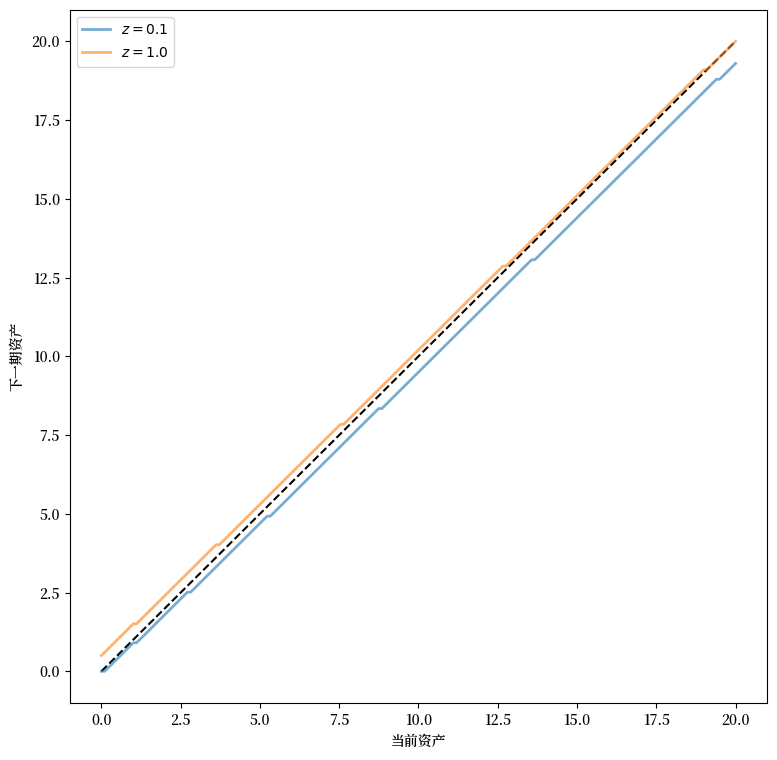

In [4]:
# 示例价格
r = 0.03
w = 0.956

# 创建Household实例
am = Household(a_max=20, r=r, w=w)

# 使用实例构建离散动态规划
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# 使用策略函数迭代求解
results = am_ddp.solve(method='policy_iteration')

# 简化名称
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

# 获取所有最优行动，在每行中固定z值
a_star = np.empty((z_size, a_size))
for s_i in range(n):
    a_i = s_i // z_size
    z_i = s_i % z_size
    a_star[z_i, a_i] = a_vals[results.sigma[s_i]]

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')  # 45度线
for i in range(z_size):
    lb = f'$z = {z_vals[i]:.2}$'
    ax.plot(a_vals, a_star[i, :], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('当前资产')
    ax.set_ylabel('下一期资产')
ax.legend(loc='upper left')

plt.show()

该图显示了在不同外生状态值下的资产积累策略。

现在我们要计算均衡。

让我们先通过可视化来做到这一点。

以下代码绘制了总供给和需求曲线。

交点给出了均衡利率和资本。

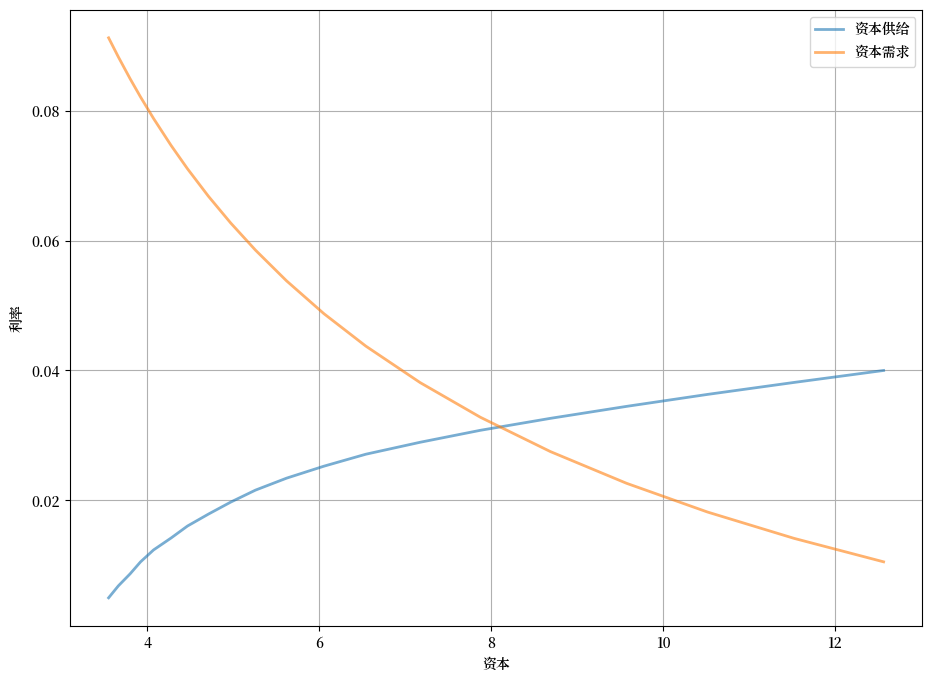

In [5]:
A = 1.0
N = 1.0
α = 0.33
β = 0.96
δ = 0.05


def r_to_w(r):
    """
    与给定利率r相关的均衡工资。
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    资本的需求反函数。与给定资本需求K相关的利率。
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    将价格映射到诱致的资本存量水平。

    参数:
    ----------

    am : Household
        aiyagari_household.Household的实例
    r : float
        利率
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)
    # 计算最优策略
    results = aiyagari_ddp.solve(method='policy_iteration')
    # 计算稳态分布
    stationary_probs = results.mc.stationary_distributions[0]
    # 提取资产的边际分布
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # 返回K
    return np.sum(asset_probs * am.a_vals)


# 创建Household实例
am = Household(a_max=20)

# 使用实例构建离散动态规划
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# 创建计算资本需求和供给的r值网格
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# 计算资本供给
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# 绘制与企业的资本需求相对
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='资本供给')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='资本需求')
ax.grid()
ax.set_xlabel('资本')
ax.set_ylabel('利率')
ax.legend(loc='upper right')

plt.show()